In [6]:
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2
from torchvision.io import read_image

%matplotlib inline
from loguru import logger


### Setup hyperparameters

In [2]:
batch_size = 32
learning_rate = 0.001
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Build dataset

In [8]:
label_map = {
    "cat": 0,
    "dog": 1,
    "horse": 2,
}

class MyImageDataset(Dataset):
    def __init__(self, csv_file, transform=None, tag="train"):
        self.transform = transform
        df = pd.read_csv(csv_file)
        df_selected = df[df["tag"] == tag]
        self.imgs = df_selected["filepath"].values
        self.labels = df_selected["label"].values

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = read_image(img_path)
        label = label_map[self.labels[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label
    

# testing
dataset = MyImageDataset(
    "data.csv",
    transform=v2.Compose([v2.Resize((128, 128)), v2.ToTensor()])
)

img, label = next(iter(dataset))
logger.info(f"{img.shape}, {label}")

/Users/mlstudio/opt/anaconda3/envs/objrecognition/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/Users/mlstudio/opt/anaconda3/envs/objrecognition/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models we

/Users/mlstudio/opt/anaconda3/envs/objrecognition/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
2024-09-29 11:27:09.648 | INFO     | __main__:<module>:36 - torch.Size([32, 3, 128, 128]), torch.Size([32])


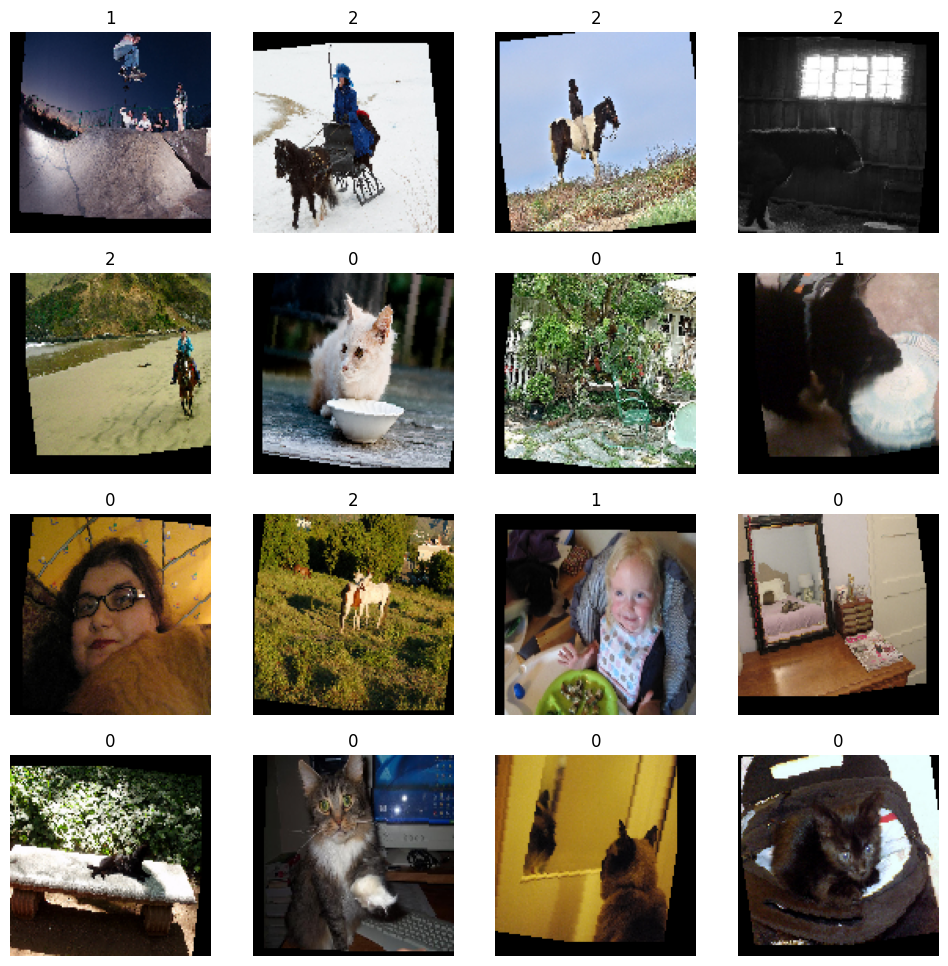

In [13]:
# build train and validation dataloaders

train_transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.RandomAffine(0, translate=(0.1, 0.1)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tranform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = MyImageDataset(
    "data.csv",
    transform=train_transform,
    tag="train"
)

val_dataset = MyImageDataset(
    "data.csv",
    transform=test_tranform,
    tag="val"
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# testing
imgs, labels = next(iter(train_loader))
logger.info(f"{imgs.shape}, {labels.shape}")
# visualize the images (4x4 grid)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    img = imgs[i].permute(1, 2, 0)
    # reverse normalization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    axes.flat[i].imshow(img)
    axes.flat[i].set_title(labels[i].item())
    axes.flat[i].axis("off")

plt.show()

### Build Pre-trained ResNet model

In [16]:
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# replace the fc layer

class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet18()

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, inputs):
        return self.model(inputs)

model = ImageClassifier(num_classes=len(label_map))
model

ImageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Setup learning

In [18]:
# define opjective function
criterion = nn.CrossEntropyLoss()

# setup Adam optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate, betas=(0.9, 0.999),
)

# setup leanring-rate scheduler (linear decay)
epoch_start_decay = num_epochs // 2
n_epochs_decay = num_epochs - epoch_start_decay
def lambda_rule(epoch):
    decay = max(0, epoch + epoch_start_decay - num_epochs)
    lr_l = 1.0 - decay / float(n_epochs_decay + 1)
    return lr_l
    
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

## Train model

In [ ]:
model.to(device)

train_metrics, val_metrics = [], []
for epoch in range(num_epochs):
    train_loss, train_acc, total = 0.0, 0.0, 0
    # run training loop
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        
        logits = model(batch_x)

        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        total += len(batch_y)
        train_loss += loss.item() * len(batch_y)
        train_acc += (preds == batch_y).sum().item()

    avg_train_loss = train_loss / total
    avg_train_acc = train_acc / total

    # run validaiton loop
    model.eval()
    val_loss, val_acc, total = 0.0, 0.0, 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in val_loader:
            batch_x_val = batch_x_val.to(device)
            batch_y_val = batch_y_val.to(device)
            logits = model(batch_x_val)
            loss = criterion(logits, batch_y_val)
            total += len(batch_y_val)
            val_loss += loss.item() * len(batch_y_val)
            val_acc += (torch.argmax(logits, 1) == batch_y_val).sum().item()
    avg_val_loss = val_loss / total
    avg_val_acc = val_acc / total
    print(
        f'Epoch {epoch}/{num_epochs}  '
        f'Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.4f}  '
        f'Val Loss: {avg_val_loss:.4f} Acc: {avg_val_acc:.4f}')

    train_metrics.append((avg_train_loss, avg_train_acc))
    val_metrics.append((avg_val_loss, avg_val_acc))